<a href="https://colab.research.google.com/github/etalab-ia/ami-ia/blob/master/notebooks/ami_ia_dataviz_rr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Premiers pas avec Jupyter Notebook et Pandas 
## Introduction
LA visalisation de données est la représentation graphique de donnée. Elle permet de communiquer l'information 


Il y a plusieurs raisons intéressantes de travailler avec Python et Pandas pour analyser et visualiser nos données. Les deux raisons principales sont :
- L'automatisation des traitements,
- La manipulation d'un grand nombre de points. 

En effet les outils généralement maitrisés par les acteurs métier opérationnels ne sont pas adaptés à ces deux raisons. L'outil principalement utilisé sur le terrain est Excel. Si on peut penser aux scripts Excel VBA pour opérer des actions routinières répétitives, dans les faits peu de monde sait se servir de ces scripts. Dès lors, on peut considérer qu'il devient intéressant de consacrer du temps à apprendre un langage permettant d'automatiser des traitements ennuyant. L'outil parfait pour ce genre de script est Python car de part les nombreuses bibliothèques maintenues par la communautés, il sait s'adapter à de nombreux cas de figure. Voir à ce sujet le site pour [automatiser les trucs ennuyants](https://automatetheboringstuff.com/). Pour une introduction à Python on peut consulter [OpenClassRoom](https://openclassrooms.com/fr/courses/235344-apprenez-a-programmer-en-python) et compléter avec un cours sur les [librairies pour la DataScience](https://openclassrooms.com/fr/courses/4452741-decouvrez-les-librairies-python-pour-la-data-science).

Dans le cadre de l'analyse de données, les bibliothèques fréquemment utilisés sont Numpy (calcul matriciel) Pandas (création de tables de données), scipy (outils mathématiques) et Matplotlib (visualisation de données). 

## Objectif 
L'objectif de ce Notebook est de faire un rapide tour des différents outils à notre disposition et d'en présenter l'utilisation lors d'un cas d'usage de la vie de tous les jours. L'idée n'est pas de sortir de ce Notebook en étant un expert de Python mais d'avoir une idée des cas d'usage du langage dans votre travail de tous les jours. 
1. Charger et comprendre les données
2. Agréger et nettoyer les données
3. Visualiser et présenter les données


# NOTES 
Plus mettre en avant le coté analyse de données que le coté outil 
plus faire une intro sur la dataviz
Plus expliquer sur l'import de données de data.gouv (screenshots? )
Rapporter au nombre de restaurant avec la base SIREN (voir pour le code APE de la restauration)

Faire aparaitre le raisonnement au fur et à mesure et faire le cheminement dans le notebook

faire plus une interraction en instaurant des questions/réponses 
Faire aussi un point dans l'intro sur Python sur comment travailler 

## Cas d'usage
Un exemple avec le jeu de données Alim'Confiance de datagouv à télécharger [ici](https://dgal.opendatasoft.com/explore/dataset/export_alimconfiance/export/?disjunctive.app_libelle_activite_etablissement&disjunctive.filtre&disjunctive.ods_type_activite) 

### Situation 
Notre but est de contrôler l'inspection des restaurants. On s'est fixé les KPI suivants et on aimerait pouvoir les suivre :
* Taux de contrôles à améliorer ou à corriger par rapport aux controles effectués. 

* Nombre de controles mensuels par région : nous voulons contrôler que les régions effectuent plus de 1 contrôle pour 100 000 Habitants par mois. 


# 1. Charger et comprendre les données
Ici faire une explication de comment on récupère les données 

In [1]:
# importer les librairies dont on aura besoin 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
"""
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
"""

'\nfrom shapely.geometry import Point\nimport geopandas as gpd\nfrom geopandas import GeoDataFrame\n'

In [2]:
# lire le jeu de données en un objet "pandas dataframe" : version online 
#df = pd.read_csv("https://dgal.opendatasoft.com/explore/dataset/export_alimconfiance/download/?format=csv&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B", sep = ";", header = 0)

# lire le jeu de données en un objet "pandas dataframe" : version offline
df = pd.read_csv('../data/export_alimconfiance.csv', sep = ";", header = 0)

## A quoi ressemblent nos données ?

In [3]:
# commande qui permet de visualiser les n premieres lignes d'une dataframe (5 par défaut)
df.head()

,APP_Libelle_etablissement,SIRET,Code_postal,Libelle_commune,Numero_inspection,Date_inspection,APP_Libelle_activite_etablissement,Synthese_eval_sanit,Agrement,geores,filtre,ods_adresse,ods_type_activite
0,LE GAULOIS,84752155600013,13100.0,AIX EN PROVENCE,2,2019-05-22T13:00:00+02:00,Restaurant,Très satisfaisant,NaN,"43.531956,5.4468",Restaurant,34 rue Jacques de la Roque,Autres
1,LE CARDEUR DE BACCHUS,82183401700013,13100.0,AIX EN PROVENCE,3,2019-05-24T13:30:00+02:00,Restaurant,Très satisfaisant,NaN,"43.529969,5.446457",Restaurant,14 Forum des cardeurs,Autres
2,CARREFOUR BAR,40829886700016,13100.0,AIX EN PROVENCE,6,2019-05-21T12:30:00+02:00,Restaurant,Très satisfaisant,NaN,"43.525265,5.453713",Restaurant,2 rue Roux Alpherand,Autres
3,LES FILS A MAMAN,83283779300021,13100.0,AIX EN PROVENCE,0,2019-06-13T13:45:00+02:00,Restaurant,Très satisfaisant,NaN,"43.528498,5.447157",Restaurant,42 rue Verrerie,Autres
4,LE FOURNIL DES CORDELIERS,48466238200023,13100.0,AIX EN PROVENCE,1,2019-06-07T11:30:00+02:00,Boulangerie-Pâtisserie,Très satisfaisant,NaN,"43.52948,5.444981",Boulangerie-Pâtisserie,67 rue des Cordeliers,Autres


In [4]:
# Nous donne des infos sur le tableau: nombre de lignes et de colonnes. Types des variables dans chacune des colonnes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38634 entries, 0 to 38633
Data columns (total 13 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   APP_Libelle_etablissement           38633 non-null  object 
 1   SIRET                               38634 non-null  object 
 2   Code_postal                         38611 non-null  float64
 3   Libelle_commune                     38634 non-null  object 
 4   Numero_inspection                   38634 non-null  object 
 5   Date_inspection                     38634 non-null  object 
 6   APP_Libelle_activite_etablissement  38634 non-null  object 
 7   Synthese_eval_sanit                 38634 non-null  object 
 8   Agrement                            9083 non-null   object 
 9   geores                              37462 non-null  object 
 10  filtre                              27957 non-null  object 
 11  ods_adresse                         37388

In [5]:
# Regardons le nombre de valeurs de valeurs différentes qu'il y a dans les activités etablissement
nb_values = len(df["APP_Libelle_activite_etablissement"].unique())
print("Il y a "+ str(nb_values)+" valeurs différentes de type d'établissement")      

Il y a 109 valeurs différentes de type d'établissement


In [6]:
# Et regardons les types le plus représentés dans notre jeu de données
df["APP_Libelle_activite_etablissement"].value_counts().head(20)

Restaurant                                                     14800
Restauration collective                                         6449
Producteur fermier                                              1792
Transformation de lait ou produits laitiers                     1351
Boucherie-Charcuterie                                           1242
Transformation de produits carnés                               1156
Boulangerie-Pâtisserie                                          1054
Alimentation générale                                            938
Chaîne d'abattage de volaille/lagomorphe/petit gibier            936
Purification/Expédition de coquillages                           867
Découpe de viande de boucherie                                   675
Libre service                                                    467
Transport de denrées alimentaires                                427
Traiteur                                                         381
Entreposage de distribution de den

In [7]:
# On limite notre analyse aux restaurants 
df = df[df["APP_Libelle_activite_etablissement"]=="Restaurant"]

In [8]:
df_copy = df.copy() #faisons une copie de notre dataFrame pour une réutilisation plus tard
# Regardons à nouveau notre dataFrame
df.head()

,APP_Libelle_etablissement,SIRET,Code_postal,Libelle_commune,Numero_inspection,Date_inspection,APP_Libelle_activite_etablissement,Synthese_eval_sanit,Agrement,geores,filtre,ods_adresse,ods_type_activite
0,LE GAULOIS,84752155600013,13100.0,AIX EN PROVENCE,2,2019-05-22T13:00:00+02:00,Restaurant,Très satisfaisant,NaN,"43.531956,5.4468",Restaurant,34 rue Jacques de la Roque,Autres
1,LE CARDEUR DE BACCHUS,82183401700013,13100.0,AIX EN PROVENCE,3,2019-05-24T13:30:00+02:00,Restaurant,Très satisfaisant,NaN,"43.529969,5.446457",Restaurant,14 Forum des cardeurs,Autres
2,CARREFOUR BAR,40829886700016,13100.0,AIX EN PROVENCE,6,2019-05-21T12:30:00+02:00,Restaurant,Très satisfaisant,NaN,"43.525265,5.453713",Restaurant,2 rue Roux Alpherand,Autres
3,LES FILS A MAMAN,83283779300021,13100.0,AIX EN PROVENCE,0,2019-06-13T13:45:00+02:00,Restaurant,Très satisfaisant,NaN,"43.528498,5.447157",Restaurant,42 rue Verrerie,Autres
5,LA CAVE DES OURS,84995458100013,13100.0,AIX EN PROVENCE,4,2019-06-13T13:30:00+02:00,Restaurant,Très satisfaisant,NaN,"43.532264,5.44666",Restaurant,20 rue Jacques de la Roque,Autres


## Comment ont évolué les résultats d'inspections au fil du temps ?

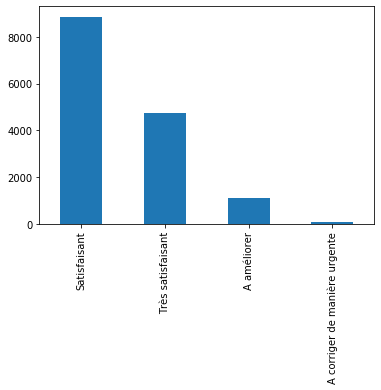

In [9]:
# regardons dans un premier temps la situation sur les bilans d'inspection
df['Synthese_eval_sanit'].value_counts().plot(kind='bar')

In [10]:
# Pour pouvoir regarder les données en fonction de la date il va falloir transformer la colonne de Date_inspection
#dans un format que Python comprend 
from datetime import datetime # on importe la librairie datetime 
def transform_date (string_date):
    #cette fonction prend l'objet string de la colonne Date_inspection et le transforme en object datetime
  datestr = string_date.split('+')[0] #remove the last bit of the data (ms) we don't need that
  return datetime.strptime(datestr,'%Y-%m-%dT%H:%M:%S') #convert the data into datetime object
# on applique cette fonction à notre colonne
df['Date_inspection'] = df['Date_inspection'].apply(lambda x : transform_date(x))

In [11]:
grouped = df.groupby([pd.Grouper(key = 'Date_inspection', freq = 'm'), 'Synthese_eval_sanit'])['filtre'].count()
#Before ploting we need to do some transforming of our 
grouped.unstack('Synthese_eval_sanit').reset_index().fillna(value = 0)

Synthese_eval_sanit,Date_inspection,A améliorer,A corriger de manière urgente,Satisfaisant,Très satisfaisant
0,2019-05-31,32.0,4.0,463.0,281.0
1,2019-06-30,79.0,6.0,977.0,548.0
2,2019-07-31,106.0,8.0,1259.0,748.0
3,2019-08-31,78.0,6.0,913.0,483.0
4,2019-09-30,90.0,8.0,838.0,395.0
5,2019-10-31,83.0,5.0,868.0,405.0
6,2019-11-30,92.0,4.0,814.0,402.0
7,2019-12-31,92.0,8.0,598.0,304.0
8,2020-01-31,158.0,6.0,868.0,481.0
9,2020-02-29,226.0,12.0,884.0,502.0


In [12]:
# Groupons les valeurs par mois et par résultat d'inspection 
grouped = df.groupby([pd.Grouper(key = 'Date_inspection', freq = 'm'), 'Synthese_eval_sanit'])['filtre'].count()
#Il est plus pratique pour présenter les données de unstack le tableau. ce qui donne :
grouped.unstack('Synthese_eval_sanit').reset_index().fillna(value = 0)

Synthese_eval_sanit,Date_inspection,A améliorer,A corriger de manière urgente,Satisfaisant,Très satisfaisant
0,2019-05-31,32.0,4.0,463.0,281.0
1,2019-06-30,79.0,6.0,977.0,548.0
2,2019-07-31,106.0,8.0,1259.0,748.0
3,2019-08-31,78.0,6.0,913.0,483.0
4,2019-09-30,90.0,8.0,838.0,395.0
5,2019-10-31,83.0,5.0,868.0,405.0
6,2019-11-30,92.0,4.0,814.0,402.0
7,2019-12-31,92.0,8.0,598.0,304.0
8,2020-01-31,158.0,6.0,868.0,481.0
9,2020-02-29,226.0,12.0,884.0,502.0


In [13]:
df_eval = grouped.unstack('Synthese_eval_sanit').reset_index().fillna(value = 0)
# On créé une varible qui liste les colonne numériques
num_cols = [col for col in df_eval.columns if df_eval[col].dtype == "float"]
#On fait la somme totale des inspections d'un mois  
df_eval['Total inspections'] = df_eval.sum(axis = 1)
# On calcule un ratio sur le nombre de résultats d'un certain type par rapport au nombre d'inspection totale
for n in num_cols:
    df_eval[n+'_ratio'] = df_eval[n]/df_eval['Total inspections']*100
df_eval.head()

Synthese_eval_sanit,Date_inspection,A améliorer,A corriger de manière urgente,Satisfaisant,Très satisfaisant,Total inspections,A améliorer_ratio,A corriger de manière urgente_ratio,Satisfaisant_ratio,Très satisfaisant_ratio
0,2019-05-31,32.0,4.0,463.0,281.0,780.0,4.102564,0.512821,59.358974,36.025641
1,2019-06-30,79.0,6.0,977.0,548.0,1610.0,4.906832,0.372671,60.683230,34.037267
2,2019-07-31,106.0,8.0,1259.0,748.0,2121.0,4.997643,0.377181,59.358793,35.266384
3,2019-08-31,78.0,6.0,913.0,483.0,1480.0,5.270270,0.405405,61.689189,32.635135
4,2019-09-30,90.0,8.0,838.0,395.0,1331.0,6.761833,0.601052,62.960180,29.676935


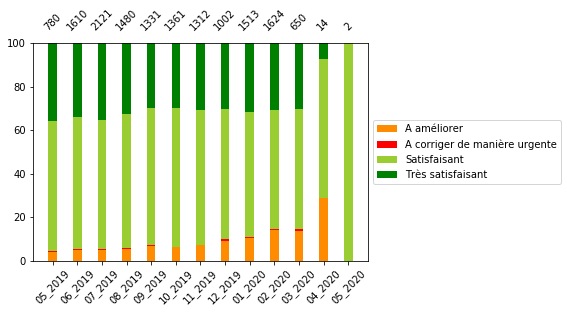

In [14]:
import numpy as np 

fig, ax = plt.subplots()
#convert the date in some strings
labels = [i.strftime('%m_%Y') for i in df_eval['Date_inspection']]
width = 0.35     # the width of the bars: can also be len(x) sequence

color_dict = {'A améliorer':'darkorange',
 'A corriger de manière urgente': 'red',
 'Satisfaisant':'yellowgreen',
 'Très satisfaisant':'green'}

bot = np.zeros(df_eval.shape[0])
for n in num_cols:
    m = n+ '_ratio'
    ax.bar(labels, df_eval[m], width, bottom = bot, label=n , color = color_dict[n])
    bot += df_eval[m]


#ax.set_ylabel('Scores')
#ax.set_title('Scores by group and gender')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

rects = ax.patches

# Make some labels.
N_insp = [str(int(i)) for i in df_eval['Total inspections'].values]

for rect, N_insp in zip(rects, N_insp):
    height = 100
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, N_insp,
            ha='center', va='bottom', rotation = 45)

plt.xticks(rotation=45)
plt.show()

# 2. Agréger et nettoyer les données
On récupère les données sur data.gouv.fr : [pour les zipcode](https://www.data.gouv.fr/en/datasets/regions-departements-villes-et-villages-de-france-et-doutre-mer/) et [pour la population](https://www.insee.fr/fr/statistiques/4265429?sommaire=4265511#consulter) 

### Nombre de contrôles par mois par région.
Pour cela il va falloir :
1. Connaître la région à laquelle le restaurant appartient 
2. Calculer le nombre de contrôles mensuels pour chacune des régions
3. Calculer le ratio de controles par rapport au nombre d'habitants 
4. Sortir une liste par région où il n'y a pas assez eu de contrôle mensuels. On pourrait se fixer comme limite minimum qu'il faut 1 controle pour 100 000 habitants tous les mois. 

In [15]:
# On charge les données dans des dataFrames 
df_cities = pd.read_csv('../data/cities.csv')
df_departments = pd.read_csv('../data/departments.csv')
df_regions = pd.read_csv('../data/regions.csv')
df_pop_regions = pd.read_csv('../data/pop_regions.csv')
cp_restaurant = pd.read_csv('../data/info_restaurants.csv')

In [16]:
# On renomme les colonnes pour les infos de régions pour mieux les utiliser plus tard
df_regions.columns = ['id', 'region_code', 'region_name', 'slug']
# On joint les données en utilisant les colonnes en commun entre les dataFrame
df_with_regions = pd.merge(df, df_cities, how= 'left', left_on = 'Code_postal', right_on = 'zip_code')
df_with_regions = pd.merge(df_with_regions, df_departments, how= 'left', left_on = 'department_code', right_on = 'code')
df_with_regions = pd.merge(df_with_regions, df_regions, how= 'left', on = 'region_code')

# Observons le résultat
df_with_regions.head()

,APP_Libelle_etablissement,SIRET,Code_postal,Libelle_commune,Numero_inspection,Date_inspection,APP_Libelle_activite_etablissement,Synthese_eval_sanit,Agrement,geores,...,gps_lat,gps_lng,id_y,region_code,code,name_y,slug_y,id,region_name,slug
0,LE GAULOIS,84752155600013,13100.0,AIX EN PROVENCE,2,2019-05-22 13:00:00,Restaurant,Très satisfaisant,NaN,"43.531956,5.4468",...,43.533834,5.509247,13.0,93,13,Bouches-du-Rhône,bouches du rhone,17.0,Provence-Alpes-Côte d'Azur,provence alpes cote dazur
1,LE GAULOIS,84752155600013,13100.0,AIX EN PROVENCE,2,2019-05-22 13:00:00,Restaurant,Très satisfaisant,NaN,"43.531956,5.4468",...,43.523233,5.546260,13.0,93,13,Bouches-du-Rhône,bouches du rhone,17.0,Provence-Alpes-Côte d'Azur,provence alpes cote dazur
2,LE GAULOIS,84752155600013,13100.0,AIX EN PROVENCE,2,2019-05-22 13:00:00,Restaurant,Très satisfaisant,NaN,"43.531956,5.4468",...,43.517019,5.594303,13.0,93,13,Bouches-du-Rhône,bouches du rhone,17.0,Provence-Alpes-Côte d'Azur,provence alpes cote dazur
3,LE GAULOIS,84752155600013,13100.0,AIX EN PROVENCE,2,2019-05-22 13:00:00,Restaurant,Très satisfaisant,NaN,"43.531956,5.4468",...,43.553539,5.527096,13.0,93,13,Bouches-du-Rhône,bouches du rhone,17.0,Provence-Alpes-Côte d'Azur,provence alpes cote dazur
4,LE GAULOIS,84752155600013,13100.0,AIX EN PROVENCE,2,2019-05-22 13:00:00,Restaurant,Très satisfaisant,NaN,"43.531956,5.4468",...,43.520782,5.504442,13.0,93,13,Bouches-du-Rhône,bouches du rhone,17.0,Provence-Alpes-Côte d'Azur,provence alpes cote dazur


## Avec le merge on a généré des duplicates. La raison est que des villes avec des noms différents partagent le même zip code. Il faut donc supprimer cette information peu utile et enlever les duplicates.

In [17]:
#keep only original columns + regions
columns = df.columns.tolist()
columns += ['region_name', 'region_code']
df_with_regions = df_with_regions.filter(items=columns)
#remove duplicates
df_with_regions.drop_duplicates(ignore_index=True, inplace= True)

## On aimerait bien aussi nettoyer les valeurs NAN que l'on voit dans les colonnes 

In [18]:
# it is usefull to check the number of nan in the table
df_with_regions.isna().sum()

APP_Libelle_etablissement                 1
SIRET                                     0
Code_postal                               6
Libelle_commune                           0
Numero_inspection                         0
Date_inspection                           0
APP_Libelle_activite_etablissement        0
Synthese_eval_sanit                       0
Agrement                              14807
geores                                  469
filtre                                    0
ods_adresse                             138
ods_type_activite                         0
region_name                              35
region_code                              35
dtype: int64

In [19]:
# cleaning of the nan in the region_code column
df_with_regions.dropna(subset=['region_code'], inplace=True)
df_with_regions.isna().sum()

APP_Libelle_etablissement                 1
SIRET                                     0
Code_postal                               6
Libelle_commune                           0
Numero_inspection                         0
Date_inspection                           0
APP_Libelle_activite_etablissement        0
Synthese_eval_sanit                       0
Agrement                              14772
geores                                  444
filtre                                    0
ods_adresse                             137
ods_type_activite                         0
region_name                               0
region_code                               0
dtype: int64

## Comment les contrôles évoluent-ils par région et par mois ? 

In [20]:
# Group the data by month and by region 
grouped = df_with_regions.groupby([pd.Grouper(key = 'Date_inspection', freq = 'm'),'region_code'])['Synthese_eval_sanit'].count()

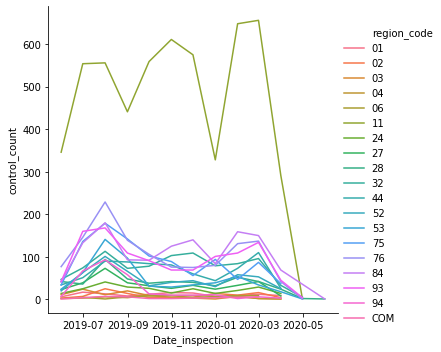

In [21]:
#Before ploting we need to do some transforming of our data
df_inspections = grouped.unstack('region_code').reset_index().melt('Date_inspection', var_name = 'region_code', value_name = 'control_count')
sns.relplot(x = 'Date_inspection', y= 'control_count', hue = 'region_code', data= df_inspections, kind = 'line')

## Bon ... on ne comprend pas grand chose avec ce graphe. Mais on sent qu'une région se démarque des autres par le nombre de contrôles, c'est l'Ile de France. Il faudrait ramener le nombre de contrôles par rapport à la population de la région ou au nombre de restaurants de la région

In [22]:
# On joint les données en utilisant les colonnes en commun entre les dataFrame
restaurants_with_regions = pd.merge(cp_restaurant, df_cities, how= 'left', left_on = 'codePostalEtablissement', right_on = 'zip_code')
restaurants_with_regions = pd.merge(restaurants_with_regions, df_departments, how= 'left', left_on = 'department_code', right_on = 'code')
restaurants_with_regions = pd.merge(restaurants_with_regions, df_regions, how= 'left', on = 'region_code')

# Observons le résultat
restaurants_with_regions.head()

,Unnamed: 0,siret,enseigne1Etablissement,codePostalEtablissement,id_x,department_code,insee_code,zip_code,name_x,slug_x,gps_lat,gps_lng,id_y,region_code,code,name_y,slug_y,id,region_name,slug
0,12558,1555034600017,LE CINTRA - L'ADAGIO,21000.0,6955.0,21,21231,21000.0,Dijon,dijon,47.325183,5.035673,20.0,27,21,Côte-d'Or,cote dor,8.0,Bourgogne-Franche-Comté,bourgogne franche comte
1,12559,1555034600025,LA TRATTORIA,73440.0,29532.0,73,73244,73440.0,Saint-Jean-de-Belleville,saint jean de belleville,45.402507,6.448191,74.0,84,73,Savoie,savoie,16.0,Auvergne-Rhône-Alpes,auvergne rhone alpes
2,12559,1555034600025,LA TRATTORIA,73440.0,29544.0,73,73257,73440.0,Les Belleville,les belleville,45.380402,6.504104,74.0,84,73,Savoie,savoie,16.0,Auvergne-Rhône-Alpes,auvergne rhone alpes
3,13201,1565125000019,NaN,21000.0,6955.0,21,21231,21000.0,Dijon,dijon,47.325183,5.035673,20.0,27,21,Côte-d'Or,cote dor,8.0,Bourgogne-Franche-Comté,bourgogne franche comte
4,14480,1605002300015,NaN,21210.0,6866.0,21,21139,21210.0,Champeau-en-Morvan,champeau en morvan,47.273896,4.150100,20.0,27,21,Côte-d'Or,cote dor,8.0,Bourgogne-Franche-Comté,bourgogne franche comte


In [23]:
#keep only original columns + regions
columns = cp_restaurant.columns.tolist()
columns += ['region_name', 'region_code']
restaurants_with_regions = restaurants_with_regions.filter(items=columns)
#remove duplicates
restaurants_with_regions.drop_duplicates(ignore_index=True, inplace= True)

In [24]:
restaurants_with_regions.head()

,Unnamed: 0,siret,enseigne1Etablissement,codePostalEtablissement,region_name,region_code
0,12558,1555034600017,LE CINTRA - L'ADAGIO,21000.0,Bourgogne-Franche-Comté,27
1,12559,1555034600025,LA TRATTORIA,73440.0,Auvergne-Rhône-Alpes,84
2,13201,1565125000019,NaN,21000.0,Bourgogne-Franche-Comté,27
3,14480,1605002300015,NaN,21210.0,Bourgogne-Franche-Comté,27
4,14481,1605002300023,LOISEAU DES SENS,21210.0,Bourgogne-Franche-Comté,27


In [25]:
nb_rest_regions = restaurants_with_regions.groupby(['region_code'])['siret'].count().reset_index(level = 'region_code')
nb_rest_regions.columns = ['region_code','nb restaurant total']
nb_rest_regions = pd.merge(nb_rest_regions, df_regions, how= 'left', on = 'region_code')

In [26]:
# on peut maintenant ajouter ces informations à notre tableau
#clean 'COM' region
df_inspections.loc[df_inspections['region_code'] == 'COM','region_code'] = '100'
nb_rest_regions.loc[nb_rest_regions['region_code'] == 'COM','region_code'] = '100'
# merge the inspection list with the population data
df_inspections = pd.merge(df_inspections, nb_rest_regions, how= 'left', left_on='region_code', right_on='region_code')
# this is what we obtained :
df_inspections.head()

,Date_inspection,region_code,control_count,nb restaurant total,id,region_name,slug
0,2019-05-31,01,6.0,3016,1,Guadeloupe,guadeloupe
1,2019-06-30,01,17.0,3016,1,Guadeloupe,guadeloupe
2,2019-07-31,01,13.0,3016,1,Guadeloupe,guadeloupe
3,2019-08-31,01,8.0,3016,1,Guadeloupe,guadeloupe
4,2019-09-30,01,12.0,3016,1,Guadeloupe,guadeloupe


In [27]:
# calculate the ratio for the population 
df_inspections['ratio_control_for1000'] = df_inspections['control_count'] / df_inspections['nb restaurant total'] * 1000

In [28]:
# let's have a look at the regions that did less that 3 inspection per 100 00 restaurants
df_few_inspections = df_inspections[df_inspections['ratio_control_for1000'] < 3.0]
df_few_inspections.head()

,Date_inspection,region_code,control_count,nb restaurant total,id,region_name,slug,ratio_control_for1000
0,2019-05-31,01,6.0,3016,1,Guadeloupe,guadeloupe,1.989390
3,2019-08-31,01,8.0,3016,1,Guadeloupe,guadeloupe,2.652520
7,2019-12-31,01,7.0,3016,1,Guadeloupe,guadeloupe,2.320955
8,2020-01-31,01,9.0,3016,1,Guadeloupe,guadeloupe,2.984085
10,2020-03-31,01,9.0,3016,1,Guadeloupe,guadeloupe,2.984085


In [29]:
df_few_inspections.groupby(['region_name'])['ratio_control_for1000'].count().sort_values(ascending = False)

region_name
La Réunion                    9
Bretagne                      7
Auvergne-Rhône-Alpes          6
Occitanie                     6
Provence-Alpes-Côte d'Azur    6
Corse                         6
Martinique                    5
Guadeloupe                    5
Centre-Val de Loire           5
Pays de la Loire              4
Nouvelle-Aquitaine            4
Normandie                     4
Bourgogne-Franche-Comté       4
Guyane                        3
Grand Est                     3
Collectivités d'Outre-Mer     3
Hauts-de-France               2
Mayotte                       1
Île-de-France                 1
Name: ratio_control_for1000, dtype: int64

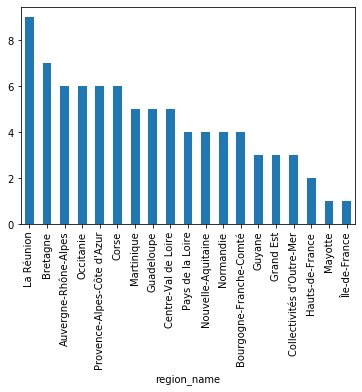

In [30]:
data = df_few_inspections.groupby(['region_name'])['ratio_control_for1000'].count().sort_values(ascending = False)
data.plot(kind = 'bar')

## OK très bien mais est-on vraiment sûr que tout le monde inspectait bien tous les mois ? 

In [31]:
# let's check that everyone was indeed inspecting stuff
df_inspections.groupby(['region_name'])['ratio_control_for1000'].count().sort_values(ascending = False)

region_name
Normandie                     13
Île-de-France                 12
Bretagne                      12
Provence-Alpes-Côte d'Azur    12
Hauts-de-France               12
Occitanie                     12
Auvergne-Rhône-Alpes          12
Nouvelle-Aquitaine            11
Martinique                    11
La Réunion                    11
Guyane                        11
Guadeloupe                    11
Grand Est                     11
Corse                         11
Centre-Val de Loire           11
Pays de la Loire              11
Bourgogne-Franche-Comté       11
Mayotte                        9
Collectivités d'Outre-Mer      7
Name: ratio_control_for1000, dtype: int64

In [32]:
# let's check that everyone was indeed inspecting stuff
df_inspections.groupby(['Date_inspection'])['ratio_control_for1000'].count().sort_values(ascending = False)

Date_inspection
2020-02-29    19
2019-10-31    19
2019-09-30    19
2019-08-31    19
2019-07-31    19
2019-06-30    19
2020-01-31    18
2019-12-31    18
2019-11-30    18
2019-05-31    18
2020-03-31    17
2020-04-30     6
2020-05-31     2
Name: ratio_control_for1000, dtype: int64

In [33]:
# looks like that due to the coronavirus, people were not inspecting in april or may 2020: let's remove these months for the analysis
df_inspections = df_inspections[df_inspections['Date_inspection'] < '2020-04']
# let's check that we removed everything 
df_inspections.groupby(['Date_inspection'])['ratio_control_for1000'].count().sort_values(ascending = False)

Date_inspection
2020-02-29    19
2019-10-31    19
2019-09-30    19
2019-08-31    19
2019-07-31    19
2019-06-30    19
2020-01-31    18
2019-12-31    18
2019-11-30    18
2019-05-31    18
2020-03-31    17
Name: ratio_control_for1000, dtype: int64

In [34]:
# let's have a look at the regions that did less that 1 inspection per 100 000 inhabitants 
df_few_inspections = df_inspections[df_inspections['ratio_control_for1000'] <  3.0]
df_few_inspections.head()

,Date_inspection,region_code,control_count,nb restaurant total,id,region_name,slug,ratio_control_for1000
0,2019-05-31,01,6.0,3016,1,Guadeloupe,guadeloupe,1.989390
3,2019-08-31,01,8.0,3016,1,Guadeloupe,guadeloupe,2.652520
7,2019-12-31,01,7.0,3016,1,Guadeloupe,guadeloupe,2.320955
8,2020-01-31,01,9.0,3016,1,Guadeloupe,guadeloupe,2.984085
10,2020-03-31,01,9.0,3016,1,Guadeloupe,guadeloupe,2.984085


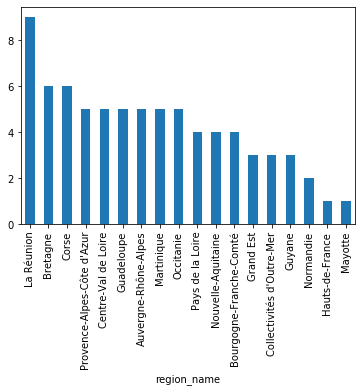

In [35]:
data = df_few_inspections.groupby(['region_name'])['ratio_control_for1000'].count().sort_values(ascending = False)
data.plot(kind = 'bar')

In [36]:
#We might want to see this on a timescale
grouped = df_few_inspections.groupby(['Date_inspection','region_name'])['ratio_control_for1000'].count().sort_values(ascending = False)
#Before ploting we need to do some transforming of our 
df_grouped_few_inspections = grouped.unstack('region_name').reset_index().melt('Date_inspection', var_name = 'Nom de la région', value_name = 'few_control_count')
grouped.unstack('region_name').reset_index()

region_name,Date_inspection,Auvergne-Rhône-Alpes,Bourgogne-Franche-Comté,Bretagne,Centre-Val de Loire,Collectivités d'Outre-Mer,Corse,Grand Est,Guadeloupe,Guyane,Hauts-de-France,La Réunion,Martinique,Mayotte,Normandie,Nouvelle-Aquitaine,Occitanie,Pays de la Loire,Provence-Alpes-Côte d'Azur
0,2019-05-31,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0
1,2019-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,2019-08-31,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-09-30,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1.0
5,2019-10-31,NaN,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,1.0
6,2019-11-30,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,1.0,1.0,NaN,1.0
7,2019-12-31,1.0,1.0,NaN,1.0,NaN,NaN,1.0,1.0,1.0,NaN,1.0,NaN,NaN,1.0,NaN,1.0,1.0,NaN
8,2020-01-31,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN
9,2020-02-29,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
df_grouped_few_inspections = grouped.unstack('region_name').reset_index().fillna(value = 0).melt('Date_inspection', var_name = 'Nom de la région', value_name = 'few_control_count')
df_grouped_few_inspections.head()

,Date_inspection,Nom de la région,few_control_count
0,2019-05-31,Auvergne-Rhône-Alpes,1.0
1,2019-06-30,Auvergne-Rhône-Alpes,0.0
2,2019-07-31,Auvergne-Rhône-Alpes,0.0
3,2019-08-31,Auvergne-Rhône-Alpes,1.0
4,2019-09-30,Auvergne-Rhône-Alpes,1.0


In [38]:
df_grouped_few_inspections = grouped.unstack('region_name').reset_index().fillna(value = 0)
df_grouped_few_inspections.head()

region_name,Date_inspection,Auvergne-Rhône-Alpes,Bourgogne-Franche-Comté,Bretagne,Centre-Val de Loire,Collectivités d'Outre-Mer,Corse,Grand Est,Guadeloupe,Guyane,Hauts-de-France,La Réunion,Martinique,Mayotte,Normandie,Nouvelle-Aquitaine,Occitanie,Pays de la Loire,Provence-Alpes-Côte d'Azur
0,2019-05-31,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
1,2019-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-07-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2019-08-31,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-09-30,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0


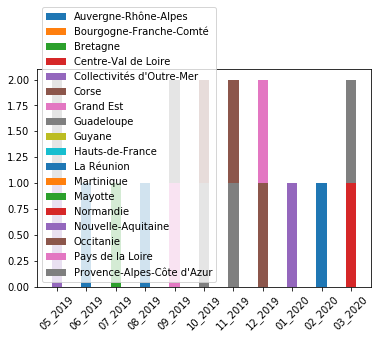

In [39]:
fig, ax = plt.subplots()
#convert the date in some strings
labels = [i.strftime('%m_%Y') for i in df_grouped_few_inspections['Date_inspection']]
width = 0.35     # the width of the bars: can also be len(x) sequence

regions = df_grouped_few_inspections.columns[1:].tolist()
bot = np.zeros(df_grouped_few_inspections.shape[0])
for r in regions:
    ax.bar(labels, df_grouped_few_inspections[r], width, bottom = bot, label=r)
    bot = df_grouped_few_inspections[r]


#ax.set_ylabel('Scores')
#ax.set_title('Scores by group and gender')
ax.legend()

plt.xticks(rotation=45)
plt.show()

Maintenant on veut pouvoir représenter les résultats des controles dans le temps


In [40]:
grouped = df.groupby([pd.Grouper(key = 'Date_inspection', freq = 'm'), 'Synthese_eval_sanit'])['filtre'].count()
#Before ploting we need to do some transforming of our 
grouped.unstack('Synthese_eval_sanit').reset_index().fillna(value = 0)

Synthese_eval_sanit,Date_inspection,A améliorer,A corriger de manière urgente,Satisfaisant,Très satisfaisant
0,2019-05-31,32.0,4.0,463.0,281.0
1,2019-06-30,79.0,6.0,977.0,548.0
2,2019-07-31,106.0,8.0,1259.0,748.0
3,2019-08-31,78.0,6.0,913.0,483.0
4,2019-09-30,90.0,8.0,838.0,395.0
5,2019-10-31,83.0,5.0,868.0,405.0
6,2019-11-30,92.0,4.0,814.0,402.0
7,2019-12-31,92.0,8.0,598.0,304.0
8,2020-01-31,158.0,6.0,868.0,481.0
9,2020-02-29,226.0,12.0,884.0,502.0


In [41]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

ModuleNotFoundError: No module named 'shapely'

In [ ]:
# créer une variable latitude et longitude à partir de la colonne geo res
set(type(x) for x in df["geores"].values.tolist())

In [ ]:
df["lat"] = df["geores"].map(lambda x: float(x.split(",")[0] if pd.isnull(x)==False else x))
df["long"] = df["geores"].map(lambda x: float(x.split(",")[1] if pd.isnull(x)==False else x))

In [ ]:
geo_df = df.dropna(subset =["lat", "long"])

In [ ]:
geometry = [Point(xy) for xy in zip(geo_df['long'], geo_df['lat'])]
gdf = GeoDataFrame(geo_df, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15)
plt.title("Répartition des restaurants notés ")

In [ ]:
geo_df_fr = geo_df[(geo_df.lat>41.12)&(geo_df.lat<51.84)&(geo_df.long<11.3)&(geo_df.long>-6.25)]

In [ ]:
sns.lmplot('long', 'lat', data=geo_df_fr, hue='Synthese_eval_sanit', fit_reg=False)
plt.title("Répartition des notes sanitaires sur le territoire")

## Ici on fait avec la population 

In [ ]:
# at this point it would be interesting to link with the region population
#clean 'COM' region
df_inspections = df_inspections[df_inspections.region_code != 'COM']
# convert region_codes to int in order to merge
df_inspections['region_code_int'] = df_inspections['region_code'].astype('int64')
# merge the inspection list with the population data
df_inspections = pd.merge(df_inspections, df_pop_regions, how= 'left', left_on='region_code_int', right_on='Code région')
# this is what we obtained :
df_inspections.head()

In [ ]:
# calculate the ratio for the population 
df_inspections['ratio_control_for100000'] = df_inspections['control_count'] / df_inspections['Population totale'] * 100000

In [ ]:
sns.set_style("whitegrid")
g = sns.relplot(x = 'Date_inspection', y= 'ratio_control_for100000', hue = 'Nom de la région', data= df_inspections, kind = 'line')
g.set(ylim=(0, 2))